<a href="https://colab.research.google.com/github/dle07/cointoss/blob/main/ML%20Models/Time_Series_Analysis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#imports
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates

In [3]:
#setting seeds for reproducibility
np.random.seed(42)
random.set_seed(42)

In [60]:
#load data

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'United States Steel Corporation w QQQ model'
symbol = 'X'

import yfinance as yf
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,56.419998,58.369999,56.209999,57.910000,52.403034,10339400
2010-01-05,58.070000,58.450001,57.270000,57.830002,52.330643,9003200
2010-01-06,57.919998,60.799999,57.849998,60.400002,54.656246,11831200
2010-01-07,60.240002,61.000000,58.869999,60.910000,55.117737,12132800
2010-01-08,60.840000,66.080002,60.759998,65.339996,59.126469,25997900


In [61]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2022-09-22,20.299999,19.450001,20.240000,19.680000,10427100,19.680000,19.680000
2022-09-23,19.070000,18.250000,18.959999,18.590000,14970500,18.590000,18.590000
2022-09-26,19.049999,18.120001,18.299999,18.200001,12488800,18.200001,18.200001
2022-09-27,18.850000,18.299999,18.540001,18.639999,16950900,18.639999,18.639999
2022-09-28,18.889999,17.889999,18.340000,18.730000,12682700,18.730000,18.730000


In [62]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3207, 6)


In [63]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_close = data.columns.get_loc("Close")

# Split the training data into train, validation, and test data sets
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.6)
valid_data_len = math.ceil(np_data_scaled.shape[0] * 0.2)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
valid_data = np_data_scaled[train_data_len:train_data_len+valid_data_len, :]
test_data = np_data_scaled[(train_data_len+valid_data_len) - sequence_length:, :]

In [64]:
#function to change data into format where x is the steps used to make the prediction and y is the prediction we want
def partition_dataset(nsteps, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(nsteps, data_len):
        x.append(data[i-nsteps:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [65]:
#use previous function to get data into right format
x_train, y_train = partition_dataset(sequence_length, train_data)
x_valid, y_valid = partition_dataset(sequence_length, valid_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [10]:
#Create The model

model = Sequential()

inputSize = x_train.shape[1] * x_train.shape[2]

model.add(LSTM(inputSize, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(inputSize, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [11]:
#Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(x_train,y_train,
                    batch_size=16,
                    epochs = 100,
                    validation_data=(x_valid, y_valid),
                    callbacks=early_stop
                    )

Epoch 1/100
118/118 [==============================] - 66s 503ms/step - loss: 0.0010 - val_loss: 1.5621e-04
Epoch 2/100
118/118 [==============================] - 48s 411ms/step - loss: 1.9946e-05 - val_loss: 2.8529e-04
Epoch 3/100
118/118 [==============================] - 49s 419ms/step - loss: 1.9535e-05 - val_loss: 1.3784e-04
Epoch 4/100
118/118 [==============================] - 48s 409ms/step - loss: 2.0352e-05 - val_loss: 1.7156e-04
Epoch 5/100
118/118 [==============================] - 50s 422ms/step - loss: 2.0638e-05 - val_loss: 2.2370e-04
Epoch 6/100
118/118 [==============================] - 48s 408ms/step - loss: 2.0534e-05 - val_loss: 1.6233e-04
Epoch 7/100
118/118 [==============================] - 48s 405ms/step - loss: 2.2053e-05 - val_loss: 1.1724e-04
Epoch 8/100
118/118 [==============================] - 48s 410ms/step - loss: 1.7482e-05 - val_loss: 1.1474e-04
Epoch 9/100
118/118 [==============================] - 48s 403ms/step - loss: 1.5282e-05 - val_loss: 1.1272e

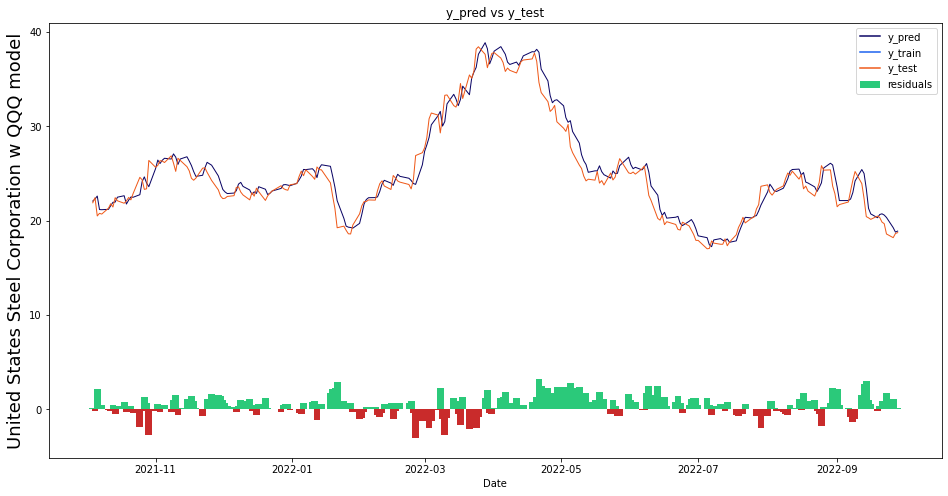

In [66]:
#Evaluate Performance

#Get predictions
y_pred_scaled = model.predict(x_test)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y = scaler_pred.inverse_transform(y_test.reshape(-1,1))

#Create a graph
display_start_date = "2021-10-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data['Close'][train_data_len+valid_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [13]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for QQQ at 2022-09-29 was 279.94
The predicted close price is 277.2799987792969 (-0.96%)


In [59]:
model.save("QQQ_Model.h5")